In [1]:
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1


In [2]:
import torch
from torchtext import data
from torchtext import datasets

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', tokenizer_language='en_core_web_sm', include_lengths = True)
LABEL = data.LabelField(dtype=torch.LongTensor)  # Changed dtype to LongTensor


In [3]:
import pandas as pd

In [5]:
df = pd.read_csv('task1_final.csv')  

In [6]:
len(df)

10000

In [7]:
df.head()

,Unnamed: 0,text,label
0,0,Senegal has partnered with a UK-based health d...,1
1,1,the man on the phone: what's it like making hi...,1
2,2,", Callum Michael RebelJenna Dewan has announce...",1
3,3,learning to live with the coronavirus q if i h...,1
4,4,"athletes allege abuse, racism at u. of illinoi...",1


In [8]:
df = df[['text','label']]

In [9]:
df[['text']] = df[['text']]. astype(str)
     

In [10]:

# text_field = data.Field(
#     sequential=True,
#     tokenize='basic_english', 
#     fix_length=500,
#     lower=True
# )
TEXT = data.Field(tokenize = 'spacy', tokenizer_language='en_core_web_sm', include_lengths = True)
LABEL = data.LabelField(sequential=False, use_vocab=False, dtype = torch.float)

# label_field = data.Field(sequential=False, use_vocab=False)

# sadly have to apply preprocess manually
preprocessed_text = df['text'].apply(
    lambda x: TEXT.preprocess(x)
)

# load fastext simple embedding with 300d
TEXT.build_vocab(
    preprocessed_text, 
    max_size = 20000,
    vectors='glove.6B.50d',
    unk_init = torch.Tensor.normal_
)

# get the vocab instance
vocab = TEXT.vocab

.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|█████████▉| 399999/400000 [00:16<00:00, 23705.63it/s]


In [11]:
ltoi = {l: i for i, l in enumerate(df['label'].unique())}

In [12]:
df['label1'] = df['label'].apply(lambda y: ltoi[y])

class DataFrameDataset(data.Dataset):
    def __init__(self, df: pd.DataFrame, fields: list):
        super(DataFrameDataset, self).__init__(
            [
                data.Example.fromlist(list(r), fields) 
                for i, r in df.iterrows()
            ], 
            fields
        )

In [13]:
df1=df[['text','label1']]

In [14]:
examples=[]
for i,row in df1.iterrows():
  # print(example)
  examples.append(data.Example.fromlist(row, fields=[('text', TEXT), ('label', LABEL)]))

In [15]:
# examples[2000].label
c=0
for i in examples:
  if type(i.label) != int:
    c+=1
     

In [16]:
c

0

In [17]:
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

In [18]:
train_dataset, test_dataset, valid_dataset = dataset.split(split_ratio=[0.6, 0.2, 0.2], stratified=True, strata_field='label')
 

In [19]:
len(train_dataset)

6000

In [20]:
ltoi

{1: 0, 0: 1}

In [21]:
import torch
torch.cuda.empty_cache()

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We are working with ", device)
# device = 'cpu'
train_iter, test_iter, valid_iter = data.BucketIterator.splits(
    datasets=(train_dataset, test_dataset, valid_dataset), 
    batch_size=16,
    sort_within_batch = True,
    sort_key=lambda x: len(x.text),
    device=device
)

We are working with  cpu


In [23]:
import torch.nn as nn
import torch.nn.functional as F

class StackedCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)



In [24]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
OUTPUT_DIM = 2
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
N_FILTERS = 100
FILTER_SIZES = [3,4,5]

model = StackedCNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,061,002 trainable parameters


In [26]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([20002, 50])


In [27]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  0.7372,  0.3910,  0.5158],
        [ 0.1825, -0.0737,  0.3147,  ...,  1.3226, -2.6796, -0.1297],
        [ 0.1516,  0.3018, -0.1676,  ..., -0.3565,  0.0164,  0.1022],
        ...,
        [-1.4322,  0.7115,  0.2418,  ...,  0.5096, -1.0170,  0.3117],
        [-0.5334, -0.7615,  0.5814,  ...,  1.4668,  0.2838,  0.8240],
        [ 0.0434, -0.1961,  0.7328,  ..., -1.6244,  0.2569, -1.4992]])

In [28]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1516,  0.3018, -0.1676,  ..., -0.3565,  0.0164,  0.1022],
        ...,
        [-1.4322,  0.7115,  0.2418,  ...,  0.5096, -1.0170,  0.3117],
        [-0.5334, -0.7615,  0.5814,  ...,  1.4668,  0.2838,  0.8240],
        [ 0.0434, -0.1961,  0.7328,  ..., -1.6244,  0.2569, -1.4992]])


In [29]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [30]:
criterion = nn.CrossEntropyLoss()

# device='cpu'
model = model.to(device)
criterion = criterion.to(device)

In [31]:
def multiclass_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # get the index of the highest prediction for each instance
    _, preds = torch.max(preds, dim=1)
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [32]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, _ = batch.text  # We are not using text_lengths
        
        predictions = model(text).squeeze(1)  # Only pass text to the model

        target = batch.label
        target = target.type(torch.LongTensor)

        loss = criterion(predictions.to(device), target.to(device))
        
        acc = multiclass_accuracy(predictions, batch.label)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [33]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            
            text, _ = batch.text  # We are not using text_lengths
            
            predictions = model(text).squeeze(1)  # Only pass text to the model
            target = batch.label
            target = target.type(torch.LongTensor)
            
            loss = criterion(predictions.to(device), target.to(device))
            
            acc = multiclass_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [34]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [35]:
train_losses_list = []
valid_losses_list = []
train_accs=[]
valid_accs=[]

In [36]:
N_EPOCHS = 25
path = "stackedCNN_model_task1.pt"
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    train_losses_list.append(train_loss)
    valid_losses_list.append(valid_loss)
    train_accs.append(train_acc*100)
    valid_accs.append(valid_acc*100)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 3m 21s
	Train Loss: 0.772 | Train Acc: 52.43%
	 Val. Loss: 0.710 |  Val. Acc: 50.05%
Epoch: 02 | Epoch Time: 3m 5s
	Train Loss: 0.689 | Train Acc: 56.97%
	 Val. Loss: 0.701 |  Val. Acc: 53.45%
Epoch: 03 | Epoch Time: 3m 8s
	Train Loss: 0.661 | Train Acc: 61.28%
	 Val. Loss: 0.685 |  Val. Acc: 56.85%
Epoch: 04 | Epoch Time: 3m 4s
	Train Loss: 0.633 | Train Acc: 64.57%
	 Val. Loss: 0.689 |  Val. Acc: 57.45%
Epoch: 05 | Epoch Time: 3m 11s
	Train Loss: 0.587 | Train Acc: 70.05%
	 Val. Loss: 0.690 |  Val. Acc: 58.60%
Epoch: 06 | Epoch Time: 3m 8s
	Train Loss: 0.548 | Train Acc: 72.83%
	 Val. Loss: 0.726 |  Val. Acc: 57.50%
Epoch: 07 | Epoch Time: 3m 8s
	Train Loss: 0.493 | Train Acc: 77.73%
	 Val. Loss: 0.746 |  Val. Acc: 58.30%
Epoch: 08 | Epoch Time: 3m 17s
	Train Loss: 0.446 | Train Acc: 80.27%
	 Val. Loss: 0.785 |  Val. Acc: 58.60%
Epoch: 09 | Epoch Time: 3m 11s
	Train Loss: 0.397 | Train Acc: 83.67%
	 Val. Loss: 0.845 |  Val. Acc: 57.90%
Epoch: 10 | Epoch Time: 

In [37]:
test_loss, test_acc = evaluate(model, test_iter, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.929 | Test Acc: 55.25%


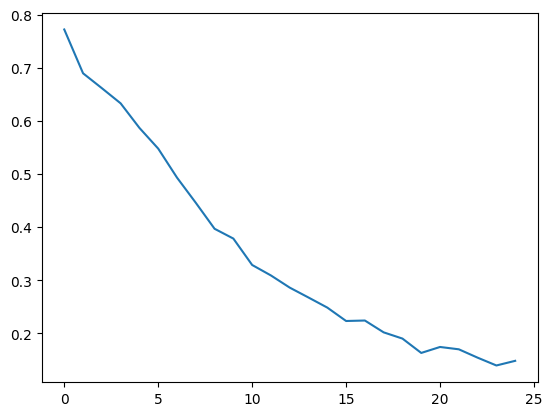

In [38]:
import matplotlib.pyplot as plt

plt.plot(train_losses_list)

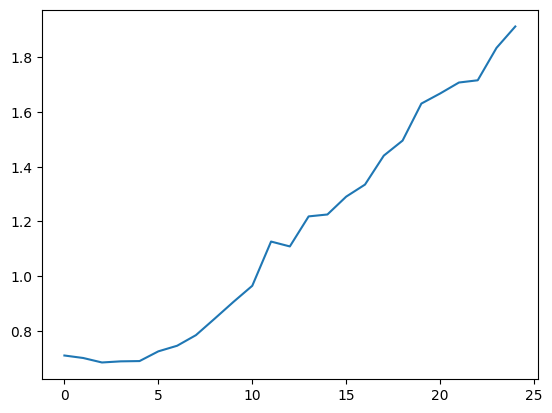

In [39]:
plt.plot(valid_losses_list)

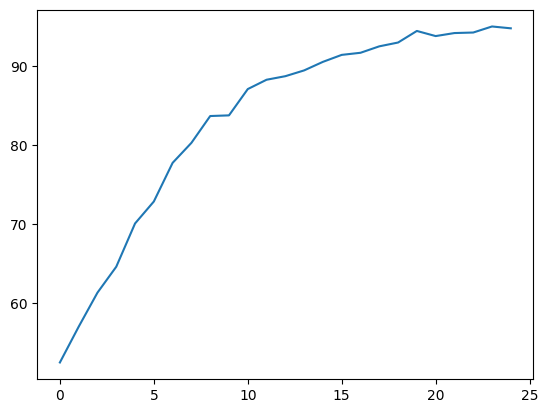

In [40]:
plt.plot(train_accs)

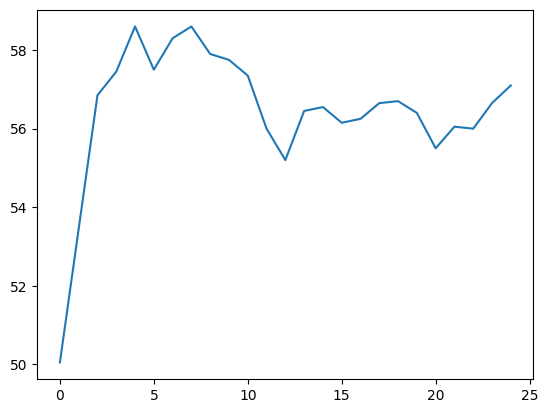

In [41]:
plt.plot(valid_accs)

In [42]:
def dataframetodataset(df):
  examples=[]
  for i,row in df.iterrows():
    # print(example)
    examples.append(data.Example.fromlist(row, fields=[('text', TEXT), ('label', LABEL)]))
    dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])
    # train_dataset, test_dataset, valid_dataset = dataset.split(split_ratio=[0.4, 0.3, 0.3], stratified=True, strata_field='label')
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # print("We are working with ", device)
    # train_iter, test_iter, valid_iter = data.BucketIterator.splits(
    #     datasets=(train_dataset, test_dataset, valid_dataset), 
    #     batch_size=16,
    #     sort_within_batch = True,
    #     sort_key=lambda x: len(x.text),
    #     device=device
    # )
  return dataset#,train_iter,test_iter,valid_iter

# **Reddit Data Evaluation**

In [43]:
import pandas as pd

In [44]:
reddit_df = pd.read_csv('reddit_data.csv')

In [45]:
reddit_df.head()

,Unnamed: 0,Title,Body,Generated Text
0,0,META: Fresh Topic Friday,[Every Friday](https://www.reddit.com/r/change...,NaN
1,1,"CMV: Demanding ""Asian people"" to have better g...",Edit:I talk about the fact that Asian applican...,NaN
2,2,CMV: Eating your lunch on the toilet is a disg...,I have a coworker who does this and it's prett...,NaN
3,3,"cmv: I don’t see transwomen as women, but don’...","Now, I don’t have any sort of hate towards tra...",NaN
4,4,CMV: there is nothing sinister or underhanded ...,I think ghost kitchens are just the inevitable...,NaN


In [46]:
reddit_df = reddit_df[['Title']]

In [47]:
reddit_df['label']=0

In [48]:

len(reddit_df)

601

In [49]:
dataset = dataframetodataset(reddit_df)

In [50]:
dataset.fields

{'text': <torchtext.data.field.Field at 0x7f915d985f90>,
 'label': <torchtext.data.field.LabelField at 0x7f915d987be0>}

In [51]:
train_dataset, test_dataset, valid_dataset = dataset.split(split_ratio=[0.4, 0.3, 0.3], stratified=True, strata_field='label')
 
     

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We are working with ", device)
train_iter, test_iter, valid_iter = data.BucketIterator.splits(
    datasets=(train_dataset, test_dataset, valid_dataset), 
    batch_size=16,
    sort_within_batch = True,
    sort_key=lambda x: len(x.text),
    device=device
)

We are working with  cpu


In [53]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
OUTPUT_DIM = 2
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
N_FILTERS = 100
FILTER_SIZES = [3,4,5]

model = StackedCNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [54]:
# model = torch.load(path)
model.load_state_dict(torch.load(path))


# Set the model to evaluation mode
# model.eval()
model = model.to(device)
     

In [55]:
evaluate(model, test_iter, criterion)

(0.5784472276767095, 0.9427083333333334)

In [56]:
evaluate(model, valid_iter, criterion)

(0.5799771845340729, 0.9635416666666666)

In [57]:
evaluate(model, train_iter, criterion)

(0.5757555524508159, 0.9791666666666666)